<a href="https://colab.research.google.com/github/Arif-PhyChem/trace_conservation/blob/main/pinn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/Arif-PhyChem/trace_conservation/blob/main/pinn.ipynb)

In [2]:
import sys
import os

! git clone https://github.com/Arif-PhyChem/MLQD.git

Cloning into 'MLQD'...
remote: Enumerating objects: 1008, done.
remote: Counting objects: 100% (284/284), done.
remote: Compressing objects: 100% (190/190), done.
remote: Total 1008 (delta 135), reused 199 (delta 93), pack-reused 724
Receiving objects: 100% (1008/1008), 34.97 MiB | 15.00 MiB/s, done.
Resolving deltas: 100% (427/427), done.


In [3]:
# install the required packages

! pip install tensorflow --upgrade
! pip install sklearn
! pip install hyperopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 95.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 87.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 84.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 30.0 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [4]:
# Add MLQD's path to system path

mlqd_dir='MLQD/dev_ver'
sys.path.append(mlqd_dir)

from evolution import quant_dyn



In [5]:
# get training and test data files from github
! git clone https://github.com/Arif-PhyChem/trace_conservation.git

Cloning into 'trace_conservation'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 154 (delta 26), reused 35 (delta 3), pack-reused 79
Receiving objects: 100% (154/154), 324.94 MiB | 14.39 MiB/s, done.
Resolving deltas: 100% (27/27), done.
Updating files: 100% (56/56), done.


# Physics Informed Neural Networks (PINNs)
In the case of PINNs, physical constraints are integrated into the loss function where an additional loss term $\mathcal{L}_\text{Tr}$ which penalizes the NN for the deviations from the trace conservation:

\begin{equation}
    \mathcal{L}_\text{PINN} =  \sum_{n=1}^N \mathcal{L}_{nn} + \omega_\text{Tr} \mathcal{L}_\text{Tr},
\end{equation}
where
\begin{equation}
    \mathcal{L}_\text{Tr} =  \sum_{m=1}^M \left( 1 - \sum_{n=1}^N \tilde{\rho}_{{\rm S},nn,m} \right)^2.
\end{equation}

\begin{equation}
    \mathcal{L}_\text{multi} =  \sum_{n=1}^N \mathcal{L}_{nn}.
\end{equation}

\begin{equation}
    \mathcal{L}_{nn} =  \sum_{m=1}^M \left(\bar{\tilde{\rho}}_{{\rm S},nn,m} - \tilde{\rho}_{{\rm S},nn,m} \right)^2,
\end{equation}

with $\bar{\tilde{\rho}}_{{\rm S},nn}$ as NN-predicted values and $\tilde{\rho}_{{\rm S},nn}$ as the reference counterpart. Furthermore, $M$ is the number of training points and $m$ is the index of a training point.

In these equations, we can tune how much the deviations from trace conservation are penalized by the weight $\omega_\text{Tr}$. Here we use $\omega_\text{Tr}=0.8$. Note that the unconstrained NN is a special case of the PINN with $\omega_\text{Tr}=0$.

To facilitate the training process, we provide pre-prepared training files named 'x.npy' and 'y.npy'. However, if you wish to create your own training files, you can utilize the MLQD tool, available on GitHub at https://github.com/Arif-PhyChem/MLQD, in conjunction with the SB dataset from the QD3SET-1 database, which can be accessed via the DOI link https://doi.org/10.25452/figshare.plus.c.6389553

## PINN model for SB model with MLQD

For quick run, we are setting training epochs 'TrEpochs' to 10, you should set it to a higher number for better training



In [6]:
# sb training files (x and y) for unconstrained NN
! ls trace_conservation/training_data/sb/pinn

x.npy  y.npy


In [7]:
# input for MLQD package, more details are given at https://github.com/Arif-PhyChem/MLQD
param={
    'n_states': 2,
      'QDmodel': 'createQDmodel',     # str: create QD model. The dafault option is useQDmodel
      'QDmodelType': 'RCDYN',           # str: The type of model. Here KRR and the default option is OSTL
      'prepInput' : 'False',           # str: Prepare input files from the data (Default 'False')
      'XfileIn': 'trace_conservation/training_data/sb/pinn/x',  # str: (Optional) The prepared X file
      'YfileIn': 'trace_conservation/training_data/sb/pinn/y',  # str: (Optional) The prepared Y file
      'hyperParam': 'False',  # str: Default is 'False', we can pass 'True' (optimize the hyperparameters) or 'False' (don't optimize and run with the default values)
      'pinn': 'True',   # model is physics-informed
      'patience': 30,
      'OptEpochs': 30,
      'TrEpochs': 10,
      'max_evals': 30,
      'systemType': 'SB',
      'QDmodelOut': 'pinn_sb_model'    # str: (Optional), providing a name to save the model at
      }
quant_dyn(**param)



MLQD is a python package developed for Machine Learning-based Quantum Dissipative Dynamics,
 				  Version 1.1.1
			 https://github.com/Arif-PhyChem/MLQD

 			 Copyright (c) 2023 Arif Ullah

All rights reserved. This work is licensed under the Apache Software License 2.0


The above copyright notice and this permission notice shall be included 
in all copies or substantial portions of the Software.


The software is provided "as is" without warranty of any kind, express or implied, 
including but not limited to the warranties ofmerchantability, fitness for a particular 
purpose and noninfringement. In no event shall the authors or copyright holders be 
liable for any claim, damages or other liability, whether in an action of contract, tort or otherwise, 
arising from, out of or in connection with the software or the use or other dealings in the software.


				 Cite as:

1) Ullah A. and Dral P. O., Computer Physics Communications, 2023, 294, 108940
2) Ullah A. and Dral P. O., New Journ

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
Running with custom loss: mse + trace penalty term
Running with custom loss: mse + trace penalty term
Running with custom loss: mse + trace penalty term
2000/2000 - 11s - 6ms/step - loss: 0.0028 - val_loss: 8.0608e-05
Epoch 2/10
2000/2000 - 6s - 3ms/step - loss: 2.5707e-04 - val_loss: 5.8772e-05
Epoch 3/10
2000/2000 - 6s - 3ms/step - loss: 2.4071e-04 - val_loss: 3.5110e-05
Epoch 4/10
2000/2000 - 5s - 3ms/step - loss: 7.9865e-05 - val_loss: 7.4762e-05
Epoch 5/10
2000/2000 - 5s - 3ms/step - loss: 7.8278e-05 - val_loss: 8.8336e-05
Epoch 6/10
2000/2000 - 11s - 6ms/step - loss: 5.0973e-05 - val_loss: 1.0780e-04
Epoch 7/10
2000/2000 - 9s - 5ms/step - loss: 5.2736e-05 - val_loss: 3.2685e-05
Epoch 8/10
2000/2000 - 5s - 2ms/step - loss: 7.1080e-05 - val_loss: 5.0990e-06
Epoch 9/10
2000/2000 - 6s - 3ms/step - loss: 2.2362e-05 - val_loss: 6.8898e-06
Epoch 10/10
2000/2000 - 10s - 5ms/step - loss: 2.9392e-05 - val_loss: 6.5191e-06
Restoring model weights from the end of the best epoch: 8

## Test for a test trajectory.

In [11]:
# test tarjectory
! ls trace_conservation/test_data/sb/

2_epsilon-0.0_Delta-1.0_lambda-0.2_gamma-10.0_beta-0.75.npy


In [19]:
# Here we are using MLQD for dynamics prediction, later we will calculate the
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
xx = np.load('trace_conservation/test_data/sb/2_epsilon-0.0_Delta-1.0_lambda-0.2_gamma-10.0_beta-0.75.npy')
x = xx[0:41,1:]

param={
    'n_states': 2,
    'time': 10,
      'QDmodel': 'useQDmodel',     # str: create QD model. The dafault option is useQDmodel
      'QDmodelType': 'RCDYN',           # str: The type of model. Here KRR and the default option is OSTL
      'XfileIn': x,           # str: (Optional) The prepared X file will be saved at the provided file name
      'cons_trace': 'False',
      'systemType': 'SB', # str: (Not optional) Need to define, wether your model is spin-boson (SB) or FMO complex (FMO)
      'QDmodelIn':  'pinn_sb_model.keras',    # str: (Optional), providing a name to save the model at
      'QDtrajOut': 'pinn_sb_traj'  # predicted trajectory will be saved with this name
      }
quant_dyn(**param)


MLQD is a python package developed for Machine Learning-based Quantum Dissipative Dynamics,
 				  Version 1.1.1
			 https://github.com/Arif-PhyChem/MLQD

 			 Copyright (c) 2023 Arif Ullah

All rights reserved. This work is licensed under the Apache Software License 2.0


The above copyright notice and this permission notice shall be included 
in all copies or substantial portions of the Software.


The software is provided "as is" without warranty of any kind, express or implied, 
including but not limited to the warranties ofmerchantability, fitness for a particular 
purpose and noninfringement. In no event shall the authors or copyright holders be 
liable for any claim, damages or other liability, whether in an action of contract, tort or otherwise, 
arising from, out of or in connection with the software or the use or other dealings in the software.


				 Cite as:

1) Ullah A. and Dral P. O., Computer Physics Communications, 2023, 294, 108940
2) Ullah A. and Dral P. O., New Journ

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 162, 80)             │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 162, 110)            │          26,510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 162, 80)             │          26,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 81, 80)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6480)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         207,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 265,442 (1.01 MB)

 Trainable params: 265,442 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

ml_dyn.RCDYN: Running recursive dynamics with CNN model......
ml_dyn.RCDYN: Dynamics is saved in a file  "pinn_sb_traj"
ml_dyn.RCDYN: Time taken = 10.762964010238647 sec
No reference trajectory was provided, so dynamics is not plotted. You can provide reference trajectory with "refTraj"
MLQD is ended at 2024-06-18 09:51:33.438070


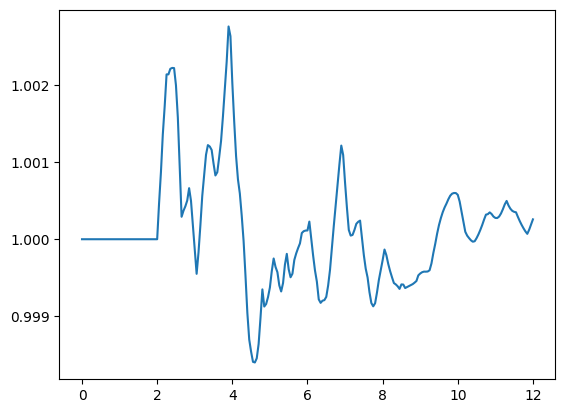

In [20]:
# Plot trace vs time
x = np.load('pinn_sb_traj.npy')
trace = np.real(x[:,1] + x[:,4])

plt.plot(x[:,0], trace)

# Let's do it for FMO complex

In [23]:
## As the datasize is quite large, we have provided at Zenodo
! wget --content-disposition https://zenodo.org/records/12065848/files/training_data.zip?download=1

--2024-06-18 09:52:03--  https://zenodo.org/records/12065848/files/training_data.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.185.79.172, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 219716862 (210M) [application/octet-stream]
Saving to: ‘training_data.zip.2’

training_data.zip.2 100%[===================>] 209.54M  18.3MB/s    in 13s     

2024-06-18 09:52:17 (16.0 MB/s) - ‘training_data.zip.2’ saved [219716862/219716862]



In [24]:
! unzip training_data

Archive:  training_data.zip
replace training_data/fmo/hc_pinn/x.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: training_data/fmo/hc_pinn/x.npy  yes

replace training_data/fmo/hc_pinn/y.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: training_data/fmo/hc_pinn/y.npy  
replace training_data/fmo/hc_pinn/y_1.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: training_data/fmo/hc_pinn/y_1.npy  
replace training_data/fmo/physics_agnostic/site_1/x.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: training_data/fmo/physics_agnostic/site_1/x.npy  
replace training_data/fmo/physics_agnostic/site_1/y.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: training_data/fmo/physics_agnostic/site_1/y.npy  
replace training_data/fmo/physics_agnostic/site_2/x.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: training_data/fmo/physics_agnostic/site_2/x.npy  
replace training_data/fmo/physics_agnostic/site_2/y.npy? [y]es, [n]o, [A]ll, [N]one, [r]enam

In [25]:
!ls

MLQD		     pinn_sb_traj.npy  trace_conservation  training_data.zip	training_data.zip.2
pinn_sb_model.keras  sample_data       training_data	   training_data.zip.1


In [27]:
# input for MLQD package, more details are given at https://github.com/Arif-PhyChem/MLQD

param={
    'n_states': 7,
      'QDmodel': 'createQDmodel',     # str: create QD model. The dafault option is useQDmodel
      'QDmodelType': 'RCDYN',           # str: The type of model. Here KRR and the default option is OSTL
      'prepInput' : 'False',           # str: Prepare input files from the data (Default 'False')
      'XfileIn': 'training_data/fmo/pinn/x',           # str: (Optional) The prepared X file
      'YfileIn': 'training_data/fmo/pinn/y',           # str: (Optional) The prepared Y file
      'hyperParam': 'False',           # str: Default is 'False', we can pass 'True' (optimize the hyperparameters) or 'False' (don't optimize and run with the default values)
      'pinn': 'True',
      'patience': 30,
      'OptEpochs': 30,
      'TrEpochs': 10,
      'max_evals': 30,
      'systemType': 'FMO',
      'QDmodelOut': 'pinn_fmo_model'    # str: (Optional), providing a name to save the model at
      }
quant_dyn(**param)

MLQD is a python package developed for Machine Learning-based Quantum Dissipative Dynamics,
 				  Version 1.1.1
			 https://github.com/Arif-PhyChem/MLQD

 			 Copyright (c) 2023 Arif Ullah

All rights reserved. This work is licensed under the Apache Software License 2.0


The above copyright notice and this permission notice shall be included 
in all copies or substantial portions of the Software.


The software is provided "as is" without warranty of any kind, express or implied, 
including but not limited to the warranties ofmerchantability, fitness for a particular 
purpose and noninfringement. In no event shall the authors or copyright holders be 
liable for any claim, damages or other liability, whether in an action of contract, tort or otherwise, 
arising from, out of or in connection with the software or the use or other dealings in the software.


				 Cite as:

1) Ullah A. and Dral P. O., Computer Physics Communications, 2023, 294, 108940
2) Ullah A. and Dral P. O., New Journ

In [ ]:
xx = np.load('trace_conservation/test_data/fmo/7_initial-1_gamma-475.0_lambda-10.0_temp-30.0.npy')

x = xx[0:41,1:]

param={
        'n_states': 7,
        'time': 2,
        'QDmodel': 'useQDmodel',     # str: create QD model. The dafault option is useQDmodel
        'QDmodelType': 'RCDYN',           # str: The type of model. Here KRR and the default option is OSTL
        'XfileIn': x,           # str: (Optional) The prepared X file will be saved at the provided file name
        'cons_trace': 'False',
        'systemType': 'FMO', # str: (Not optional) Need to define, wether your model is spin-boson (SB) or FMO complex (FMO)
        'QDmodelIn': 'pinn_fmo_model.keras',    # str: (Optional), providing a name to save the model at
        'QDtrajOut': 'pinn_fmo_traj'  # predicted trajectory will be saved with this name
      }
quant_dyn(**param)


MLQD is a python package developed for Machine Learning-based Quantum Dissipative Dynamics,
 				  Version 1.1.1
			 https://github.com/Arif-PhyChem/MLQD

 			 Copyright (c) 2023 Arif Ullah

All rights reserved. This work is licensed under the Apache Software License 2.0


The above copyright notice and this permission notice shall be included 
in all copies or substantial portions of the Software.


The software is provided "as is" without warranty of any kind, express or implied, 
including but not limited to the warranties ofmerchantability, fitness for a particular 
purpose and noninfringement. In no event shall the authors or copyright holders be 
liable for any claim, damages or other liability, whether in an action of contract, tort or otherwise, 
arising from, out of or in connection with the software or the use or other dealings in the software.


				 Cite as:

1) Ullah A. and Dral P. O., Computer Physics Communications, 2023, 294, 108940
2) Ullah A. and Dral P. O., New Journ

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 2007, 80)            │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 2007, 110)           │          26,510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 2007, 80)            │          26,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 1003, 80)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 80240)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │       2,567,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 49)                  │           6,321 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,631,567 (10.04 MB)

 Trainable params: 2,631,567 (10.04 MB)

 Non-trainable params: 0 (0.00 B)

ml_dyn.RCDYN: Running recursive dynamics with CNN model......


In [ ]:
# Plot trace vs time
x = np.load('pinn_fmo_traj.npy')
trace = np.real(x[:,1] + x[:,9] + x[:,17] + x[:,25] + x[:,33] + x[:, 41] + x[:,49])

plt.plot(x[:,0], trace)